In [4]:
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import csv
import operator
import Geohash
from error import SquareError
%matplotlib inline

In [2]:
# we need formaula to compute distance between two points

#Since the distance is relatively small, you can use the equirectangular distance approximation
def haversine(point1, point2):
    # radius of the earth in km
    R = 6371 
    # get lat and lon
    lon1, lat1 = point1[0], point1[1]
    lon2, lat2 = point2[0], point2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # formula
    x = (lon2 - lon1) * math.cos( 0.5*(lat2+lat1) )
    y = lat2 - lat1
    d = R * math.sqrt( x*x + y*y )
    return d


In [3]:
# Longitude and latitude coordinates of Porto
point_mid = [-8.6109900, 41.1496100] #lon, lat

#Porto airport coordinates
point_air = [-8.671403, 41.237137]

## 1. Data loading and selection

In [12]:
# Load the data
#zf = zipfile.ZipFile('train.csv.zip')
df = pd.read_csv('train.csv', 
                 sep = ",",
                 chunksize = 1000,
                 iterator = True,
                 usecols = ['POLYLINE', 'MISSING_DATA'],
                 converters={'POLYLINE': lambda x: json.loads(x)})

In [13]:
initial_radius = 1.5 #km
#df_airport = pd.DataFrame()

In [14]:
traj_df = pd.DataFrame()

for data in df:
    #print data
    for index, row in data.iterrows():
        if len(row["POLYLINE"]) > 0:
            if haversine(row["POLYLINE"][0], point_air) <= initial_radius:
                row['Destination'] = row['POLYLINE'][-1]
                traj_df = traj_df.append(row, ignore_index=True)

In [60]:
air_traj_list = []
for data in df:
    #print data['POLYLINE']
    for coords in data['POLYLINE']:
        if len(coords) > 0:
            if haversine(coords[0], point_air) <= initial_radius:
                #print "Yes"
                air_traj_list.append(coords)
                
    break
    

In [22]:
traj_df['MISSING_DATA'].value_counts()

0    4328
Name: MISSING_DATA, dtype: int64

In [23]:
traj_df.to_csv('air_trajs.csv')
#df.to_csv(file_name, sep='\t')

In [50]:
with open("air_traj.csv", "wb") as f:
    writer = csv.writer(f, delimiter=',',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerows(air_traj_list)

In [86]:
# Let's see end points of selected trips

In [130]:
start_points = np.array([trip[0] for trip in air_traj_list])
end_points = np.array([trip[-1] for trip in air_traj_list])
latlong = end_points.copy()

In [101]:
# cut off long distance trips
lat_low, lat_hgh = np.percentile(latlong[:,0], [2, 98])
lon_low, lon_hgh = np.percentile(latlong[:,1], [2, 98])

# create image
bins = 513
lat_bins = np.linspace(lat_low, lat_hgh, bins)
lon_bins = np.linspace(lon_low, lon_hgh, bins)
H2, _, _ = np.histogram2d(latlong[:,0], latlong[:,1], bins=(lat_bins, lon_bins))

img = np.log(H2[::-1, :] + 1)

plt.figure()
ax = plt.subplot(1,1,1)
plt.imshow(img)
plt.axis('off')
plt.title('Taxi trip end points')
plt.savefig("taxi_trip_end_points.png")

In [131]:
start_lats = [p[1] for p in start_points]
start_lons = [p[0] for p in start_points]

end_lats = [p[1] for p in end_points]
end_lons = [p[0] for p in end_points]


In [135]:
import gmplot

gmap = gmplot.GoogleMapPlotter(41.1496100, -8.6109900 , 12)

#gmap.plot(heat_lats, heat_lons, 'cornflowerblue', edge_width=10)
#gmap.scatter(heat_lats, heat_lons, '#3B0B39', size=10, marker=False)
gmap.scatter(start_lats, start_lons, '#006400', size=10, marker=False)
gmap.scatter(end_lats, end_lons, '#8B0000', size=10, marker=False)

#gmap.heatmap(heat_lats, heat_lons)

gmap.draw("mymap.html")

## 2. Work with extracted data

In [5]:
air_trajs = pd.read_csv('air_trajs.csv',
                        #index_col=,
                        usecols = ['POLYLINE', 'Destination'],
                        converters={'POLYLINE': lambda x: json.loads(x), 'Destination': lambda x: json.loads(x)})

In [6]:
decision_points = []
end_points = np.array([trip[-1] for trip in air_trajs['POLYLINE']])
start_points = np.array([trip[0] for trip in air_trajs['POLYLINE']])

In [51]:
def haversine(point1, point2):
    # radius of the earth in km
    R = 6371
    # get lat and lon
    lon1, lat1 = point1[0], point1[1]
    lon2, lat2 = point2[0], point2[1]
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # formula
    x = (lon2 - lon1) * math.cos( 0.5*(lat2+lat1) )
    y = lat2 - lat1
    d = R * math.sqrt( x*x + y*y )
    return d


def get_geohash_index(points, precision=12):
    """
    get a list of geohash
    :param points: a list of GPS points
    :param precision: the length of a geohash binary string, the longer the string is the more precise the geohash is
    :return: a list of geohash (binary strings)
    """
    geo_index = [Geohash.encode(latitude=p[1], longitude=p[0], precision=precision) for p in points]
    return geo_index


def sort(points, targets):
    """
    sort points and target according to geohash of points
    :param points: a list of gps points
    :param targets: a list of target
    :return: sorted points and targets
    """
    geo_index = get_geohash_index(points)
    tuples = list()
    n = len(geo_index)
    for i in range(n):
        tuples += [(geo_index[i], points[i], targets[i])]

    # sort the tuples according to the order of geohash
    tuples = sorted(tuples, key=lambda x: x[0])

    #print "tuples", tuples
    # create new points and targets in sorted order
    new_points = []
    new_target = []
    for i in range(n):
        new_points += [tuples[i][1]]
        new_target += [tuples[i][2]]
        
    return np.array(new_points), np.array(new_target)


def find_decision_point(points, targets, max_radius=1):
    """
    find the best decision point and radius
    :param points: a list of points
    :param targets: a list of target (np.array)
    :param max_radius: maximum radius to consider (Km)
    :return: the best decision point and radius
    """
    sorted_points, sorted_targets = sort(points, targets)
    best_radius = None
    best_gain_so_far = 0
    best_decision_point = None
    print "len", len(sorted_points)
    #for idx in range(len(sorted_points)):
    for idx in range(2):
        print "point id:", idx, sorted_points[idx]
        radius, gain = find_best_radius(idx, sorted_points, sorted_targets, max_radius)
        if best_gain_so_far < gain:
            best_gain_so_far = gain
            best_decision_point = sorted_points[idx]
            best_radius = radius
    return best_decision_point, best_radius


def find_best_radius(idx, points, targets, max_radius=1):
    """
    find the best radius for a point with index idx
    :param idx: index of the decision point
    :param points: a list of gps points, sorted according to geohash order
    :param targets: a list of corresponding targets
    :param max_radius: maximum radius to consider for search
    :return: the best radius and maximum gain
    """
    n = len(points)
    # square error of the points outside the circle, from the beginning all points are outside the circle
    outside = SquareError()

    outside.add_list(targets)
    all_se = outside.sum_of_square_error()

    # square error of the points outside the circle, from the beginning no point is inside the circle
    inside = SquareError()

    left_idx = idx
    right_idx = idx
    current_radius = 0
    gain = 0
    best_radius = -1
    while current_radius < max_radius:
        if left_idx > 0 and right_idx < n-1:
            # if there are elements to the right and to the left
            distance_to_next_left = haversine(points[idx], points[left_idx - 1])
            distance_to_next_right = haversine(points[idx], points[right_idx + 1])
            #print "left", distance_to_next_left
            #print "right", distance_to_next_right
            if distance_to_next_left < distance_to_next_right:
                # move to the left
                current_radius = distance_to_next_left
                while distance_to_next_left == current_radius:
                    inside.add(points[left_idx])
                    outside.remove(points[left_idx])
                    left_idx -= 1
                    if left_idx == 0:
                        break
                    else:
                        distance_to_next_left = haversine(points[idx], points[left_idx - 1])
                current_radius = haversine(points[idx], points[left_idx])
            elif distance_to_next_left > distance_to_next_right:
                # move to the right
                current_radius = distance_to_next_right
                while distance_to_next_right == current_radius:
                    inside.add(points[right_idx])
                    outside.remove(points[right_idx])
                    right_idx += 1
                    if right_idx == n-1:
                        break
                    else:
                        distance_to_next_right = haversine(points[idx], points[right_idx + 1])
            else:
                # if distance_to_next_left == distance_to_next_right, move to both size until there is no tight
                # move to the left
                current_radius = distance_to_next_left
                #left move
                while distance_to_next_left == current_radius:
                    inside.add(points[left_idx])
                    outside.remove(points[left_idx])
                    left_idx -= 1
                    if left_idx == 0:
                        break
                    else:
                        distance_to_next_left = haversine(points[idx], points[left_idx - 1])
                        
                #right move
                while distance_to_next_right == current_radius:
                    inside.add(points[right_idx])
                    outside.remove(points[right_idx])
                    right_idx += 1
                    if right_idx == n-1:
                        break
                    else:
                        distance_to_next_right = haversine(points[idx], points[right_idx + 1])
        elif left_idx == 0 and right_idx < n-1:
            # if no element to the left but still elements to the right
            distance_to_next_right = haversine(points[idx], points[right_idx + 1])
            current_radius = distance_to_next_right
            while distance_to_next_right == current_radius:
                inside.add(points[right_idx])
                outside.remove(points[right_idx])
                right_idx += 1
                if right_idx == n-1:
                    break
                else:
                    distance_to_next_right = haversine(points[idx], points[right_idx + 1])
        elif right_idx == n-1 and left_idx > 0:
            # if no element on the right but still elements on the left
            distance_to_next_left = haversine(points[idx], points[left_idx - 1])
            current_radius = distance_to_next_left
            while distance_to_next_left == current_radius:
                inside.add(points[left_idx])
                outside.remove(points[left_idx])
                left_idx -= 1
                if left_idx == 0:
                    break
                else:
                    distance_to_next_left = haversine(points[idx], points[left_idx - 1])

        else:
            break

        # update gain
        outside_se = outside.sum_of_square_error()
        inside_se = inside.sum_of_square_error()
        new_gain = all_se - outside_se - inside_se
        if gain < new_gain:
            gain = new_gain
            best_radius = current_radius
    return best_radius, gain

In [12]:
def mean_points_alpha(points):
    lats = [point[0] for point in points]
    lons = [point[1] for point in points]
    return [np.mean(lats), np.mean(lons)]

def sqare_error_alpha(points):
    pmean = mean_points_alpha(points)
    #print np.mean(np.power([haversine(point, pmean) for point in points], 2))
    return np.mean(np.power([haversine(point, pmean) for point in points], 2))
    
def index_points_in_circe(center, radius, points):
    indexes = []
    for index, point in points.iteritems():
        if haversine(center, point) <= radius:
            indexes.append(index)
            
    return indexes

def get_start_points(trajs):
    start_points = trajs.copy()
    for index, row in start_points.iteritems():
        start_points[index] = row[0]
    
    return start_points

In [24]:
start_points = get_start_points(air_trajs['POLYLINE'])

In [52]:
decision_point = find_decision_point(start_points, air_trajs['Destination'])

len 4328
point id: 0 [ -8.681355  41.22594 ]
point id: 1 [ -8.683371  41.227596]


In [53]:
decision_point

(array([ -8.683371,  41.227596]), 1.201497533127739)

In [24]:
range(1,2)

[1]

In [125]:
def find_decision_point(start_points, targets):
    eps = 0.001
    gains = []
    
    for index, point in start_points[2:5].iteritems():
        p_gains = []
        nn = 1
        radius = eps
        p_error = sqare_error_alpha(targets)
        print 'start'
        
        while(nn < len(start_points)):
            n_indexes = index_points_in_circe(point, radius, start_points)

            if nn < len(n_indexes):
                nn = len(n_indexes)
                
                mse_in = float(len(n_indexes))/len(targets) * sqare_error_alpha(targets[n_indexes])
                mse_out = float(len(targets) - len(n_indexes))/len(targets) * sqare_error_alpha(targets.drop(n_indexes))
                
                gain = p_error - (mse_in + mse_out)
                p_gains.append((index, radius, gain))
                
                radius += eps
            else:
                radius += eps
                
        gains.append(max(p_gains, key=operator.itemgetter(2)))
        
    best_gain = max(gains, key=operator.itemgetter(2))
    d_point = (start_points[best_gain[0]], best_gain[1])

    return d_point
    

In [126]:
start_points = get_start_points(air_trajs['POLYLINE'])

In [127]:
gains = find_decision_point(start_points, air_trajs['Destination'])

start
start
start


In [117]:
gains

([-8.670006, 41.2371], 0.05300000000000004)

In [104]:
air_trajs['Destination'][best[0]]

[-8.668224, 41.238657]

In [72]:
x = range(len(gains))
sigmas = np.array(gains)
print np.where((gains)==max(gains))
print len(x)

(array([337]),)
804


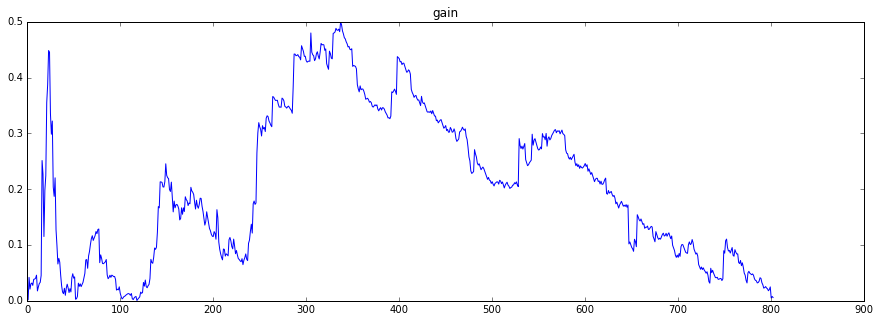

In [73]:
plt.figure(1, figsize=(15,5))
plt.subplot(111)
plt.title('gain')
plt.plot(x, gains)

plt.show()

In [154]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

X = np.array(list(start_points))

distance_matrix = squareform(pdist(X, (lambda u,v: haversine(u,v))))

In [183]:
db = DBSCAN(eps=0.01, min_samples=2, metric='precomputed')  # using "precomputed" as recommended by @Anony-Mousse
y_db = db.fit_predict(distance_matrix)

x = np.c_[ X, np.zeros(len(X)) ]  
x[:,2] = y_db



In [193]:
len(x[x[:,2] == 0])

3163

In [189]:
print np.unique(x[:,2], return_counts=True)


(array([  -1.,    0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,
          8.,    9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,
         17.,   18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,
         26.,   27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,
         35.,   36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,
         44.,   45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,
         53.,   54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,
         62.,   63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,
         71.,   72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,
         80.,   81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,
         89.,   90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,
         98.,   99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,
        107.,  108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,
        116.,  117.,  118.,  119.,  120.,  121.,  122.,  123.,  124.,
        125.,  126.

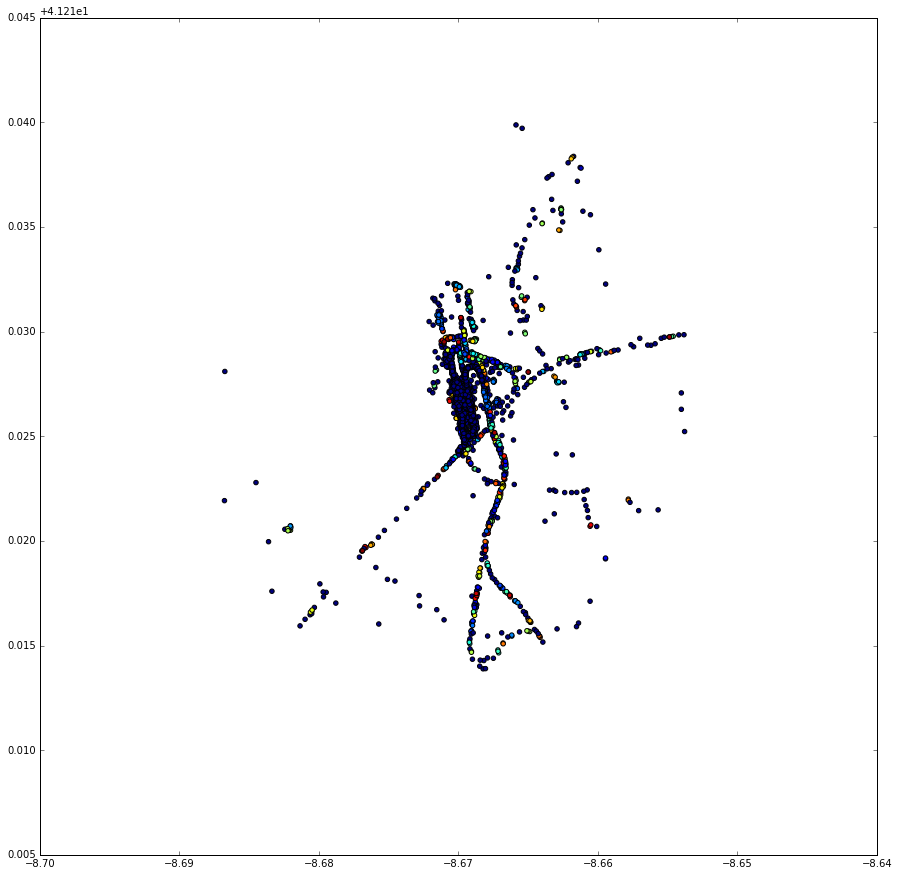

In [198]:
plt.figure(1, figsize=(15,15))
a = x[x[:,2] == 0]
plt.scatter(x[:,0], x[:,1], c=x[:,2])
plt.show()

In [180]:
x[2]

array([ -8.669646,  41.237271,   0.      ])

In [164]:
np.c_[ X, np.zeros(len(X)) ]  

array([[ -8.669367,  41.235057,   0.      ],
       [ -8.669628,  41.234859,   0.      ],
       [ -8.669646,  41.237271,   0.      ],
       ..., 
       [ -8.667   ,  41.236434,   0.      ],
       [ -8.667324,  41.232744,   0.      ],
       [ -8.66754 ,  41.238549,   0.      ]])

## GEO HASH

In [110]:
def index_points_in_circe(center, radius, points):
    indexes = []
    for index, point in points.iteritems():
        if haversine(center, point) <= radius:
            indexes.append(index)
            
    return indexes

In [111]:
start_points

0       [-8.669367, 41.235057]
1       [-8.669628, 41.234859]
2       [-8.669646, 41.237271]
3         [-8.670006, 41.2371]
4       [-8.669259, 41.236668]
5       [-8.670015, 41.236965]
6       [-8.669295, 41.241303]
7       [-8.669583, 41.236254]
8       [-8.669295, 41.241285]
9         [-8.6706, 41.233761]
10      [-8.669493, 41.236974]
11      [-8.669088, 41.235048]
12      [-8.661645, 41.238675]
13        [-8.668017, 41.2353]
14      [-8.669709, 41.235597]
15      [-8.669493, 41.237838]
16      [-8.672193, 41.232726]
17      [-8.669205, 41.236848]
18      [-8.670078, 41.237424]
19       [-8.66979, 41.236434]
20      [-8.669376, 41.237289]
21       [-8.66763, 41.231088]
22      [-8.668539, 41.238279]
23      [-8.666973, 41.234301]
24      [-8.661276, 41.247846]
25       [-8.669934, 41.23674]
26      [-8.660754, 41.231457]
27       [-8.66979, 41.235813]
28      [-8.670159, 41.237505]
29      [-8.669952, 41.236452]
                 ...          
4298    [-8.669718, 41.235516]
4299    